In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np

np.random.seed(0)

import torch

torch.manual_seed(0)
torch.set_default_dtype(torch.double)

import gpytorch

import sys

sys.path.append("../")

from utils.constants import CATS, ANS, FEATURES, TARGET_NOISE, TARGET

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm import tqdm
import wandb

In [2]:
track_wandb = False

without_feature = False
if without_feature:
    name = "w/o feature"
else:
    name = "w feature"

# min_lengthscale = 1e-1
# max_lengthscale = 1e0

learn_additional_noise = False

num_iters = 2000

# training

In [3]:
cols = CATS + ANS + FEATURES + [TARGET_NOISE, TARGET]
num_dims = len(CATS) + len(ANS)

df = pd.read_csv("../data/free_energies_031522.csv")[cols]
df

,Pb,Sn,Ge,Te,Se,S,var_vol_norm,Uncertainty (meV/fu),Hmix_unk (meV/fu)
0,0.333333,0.333333,0.333333,0.000000,0.500000,0.500000,0.009763,1.471047,27.352267
1,0.000000,1.000000,0.000000,0.500000,0.500000,0.000000,0.006110,1.035332,28.269825
2,1.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.016794,1.770743,72.108514
3,1.000000,0.000000,0.000000,0.000000,0.250000,0.750000,0.001836,0.315186,12.684210
4,1.000000,0.000000,0.000000,0.166667,0.416667,0.416667,0.008908,1.530357,42.614178
...,...,...,...,...,...,...,...,...,...
66,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.010000,0.000000
67,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.010000,0.000000
68,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.010000,0.000000
69,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.010000,0.000000


In [4]:
train_x = df[cols[:-2]].values
train_x = torch.tensor(train_x).double()
train_x.shape

torch.Size([71, 7])

In [5]:
noise_train = df[cols[-2]].values
noise_train = torch.tensor(noise_train)

print(noise_train.shape)
noise_train

torch.Size([71])


tensor([1.4710, 1.0353, 1.7707, 0.3152, 1.5304, 3.2570, 0.4510, 1.8592, 1.7219,
        0.8856, 2.7601, 1.4802, 0.5052, 1.6419, 2.4526, 1.5393, 1.2662, 0.7511,
        1.0137, 0.5045, 0.4138, 0.7215, 2.7426, 1.6263, 1.6330, 1.9146, 1.4154,
        0.6421, 0.3120, 1.2501, 0.8812, 1.5924, 2.7483, 0.8012, 0.4766, 0.3574,
        1.3297, 1.8167, 2.5327, 1.7757, 1.8324, 0.9836, 0.5459, 1.3685, 1.6970,
        0.3777, 0.9773, 1.4641, 1.1091, 0.9099, 0.3566, 1.1297, 1.4718, 1.2409,
        1.4151, 0.2989, 1.0383, 1.1447, 1.2640, 1.3446, 1.0988, 1.1203, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100])

In [6]:
train_y = df[cols[-1]].values
train_y = torch.tensor(train_y)

mean_y = train_y.mean().item()
std_y = train_y.std().item()

train_y = (train_y - mean_y) / std_y
unnormalize_fn = lambda x: (x * std_y + mean_y, x * std_y)

print(train_y.shape)
train_y

torch.Size([71])


tensor([-0.2090, -0.1647,  1.9474, -0.9157,  0.5264,  1.7405, -0.4870,  1.1339,
        -0.8681, -0.5431,  0.8870,  1.7496, -0.7208,  0.9773,  1.5996,  1.0335,
         0.9415, -0.1106, -0.0562,  0.0118, -0.3419, -0.2521,  1.9118,  0.1043,
        -0.4338,  0.9283, -0.8386, -0.5898, -1.0080,  0.5141, -0.0735,  1.5831,
        -0.6234,  1.0297, -0.7848, -0.8947,  0.5998,  1.0878,  1.4099,  0.3792,
         1.7585, -0.1515, -0.6683,  0.5867,  0.6320, -1.0069, -0.3258, -0.7816,
        -0.2253, -0.3409, -0.9643,  0.6335,  0.0522,  0.6172,  1.5177, -0.9344,
         0.0486,  0.0180,  1.0693, -0.1910,  0.1764,  0.0407, -1.5268, -1.5268,
        -1.5268, -1.5268, -1.5268, -1.5268, -1.5268, -1.5268, -1.5268])

In [7]:
mean_y, std_y

(31.68914619239437, 20.75522871885851)

In [8]:
linear_regressor = LinearRegression()
linear_regressor.fit(train_x[:, [-1]].detach().numpy(), train_y.detach().numpy())

linear_regressor.coef_, linear_regressor.intercept_

(array([145.68982337]), -1.1515415588298725)

In [9]:
class CustomLinearMean(gpytorch.means.Mean):
    def __init__(self, batch_shape=torch.Size()):
        super().__init__()

        self.register_parameter(
            "weight", parameter=torch.nn.Parameter(torch.tensor(linear_regressor.coef_))
        )
        self.register_parameter(
            "bias",
            parameter=torch.nn.Parameter(torch.tensor(linear_regressor.intercept_)),
        )

    def forward(self, x):
        return torch.matmul(x[:, num_dims:], self.weight) + self.bias


class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        if not without_feature:
            self.mean_module = CustomLinearMean()
        else:
            self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=num_dims,
                # lengthscale_constraint=gpytorch.constraints.Interval(
                #     min_lengthscale, max_lengthscale
                # ),
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x[:, :num_dims])
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
    noise=(noise_train / std_y) ** 2, 
    learn_additional_noise=learn_additional_noise,
    noise_constraint=gpytorch.constraints.LessThan(1) if learn_additional_noise else None
)

model = GPModel(train_x, train_y, likelihood)

In [11]:
try:
    print(
        model.mean_module.weight.item(),
        model.mean_module.bias.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )
except AttributeError:
    print(
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )

145.68982337490445 -1.1515415588298725 0.6931471805599453 [[0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718]]


In [12]:
if track_wandb:
    wandb_run = wandb.init(project="phase-mapping", entity="quanwustl")
    wandb_run.name = name

In [13]:
# train the hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

for i in tqdm(range(num_iters)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    
    if track_wandb:
        log_dict = {}
        log_dict["iter"] = i
        
        log_dict["loss"] = loss.item()
        
        if not without_feature:
            log_dict["weight"] = model.mean_module.weight.item()
            log_dict["bias"] = model.mean_module.bias.item()
        else:
            log_dict["constant"] = model.mean_module.constant.item()
            
        log_dict["output scale"] = model.covar_module.outputscale.item()
        
        lengthscales = model.covar_module.base_kernel.lengthscale.detach().numpy().flatten().tolist()
        for l_ind, l in enumerate(lengthscales):
            log_dict[f"length scale for {(CATS + ANS)[l_ind]}"] = l
        
        wandb_run.log(log_dict)

    optimizer.step()

model.eval()
likelihood.eval()

# plt.figure(figsize=(8, 6))
# plt.plot(losses);

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
100%|██████████| 2000/2000 [00:03<00:00, 507.24it/s]


FixedNoiseGaussianLikelihood(
  (noise_covar): FixedGaussianNoise()
)

In [14]:
for p in model.named_parameters():
    print(p)

('mean_module.weight', Parameter containing:
tensor([162.5040], requires_grad=True))
('mean_module.bias', Parameter containing:
tensor(-1.5897, requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(-1.5442, requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-0.1515,  0.0087, -1.1714, -1.4311,  2.2852, -0.7084]],
       requires_grad=True))


In [15]:
try:
    print(
        model.mean_module.weight.item(),
        model.mean_module.bias.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )
except AttributeError:
    print(
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )

162.50395615462884 -1.5897009004648546 0.19349900622575036 [[0.62028522 0.69752211 0.26997719 0.21434644 2.38207786 0.40039283]]


# inference

In [16]:
from utils.plotting import plot_regressor_square_edges, plot_regressor_square

In [21]:
test_cols = CATS + ANS + FEATURES
space_df = pd.read_csv("../data/space_w_feats_0329.csv")[test_cols]

test_x = torch.tensor(space_df.values).double()
test_x.shape

torch.Size([91809, 7])

In [22]:
with torch.no_grad():
    pred_distribution = model(test_x)
    pred_mean = pred_distribution.mean
    pred_sd = pred_distribution.stddev

In [23]:
space_df["pred_mean"] = unnormalize_fn(pred_mean.detach())[0].numpy()
space_df["pred_sd"] = unnormalize_fn(pred_sd.detach())[1].numpy()

In [24]:
space_df.to_csv("../data/predictions.csv", index=False)

/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.

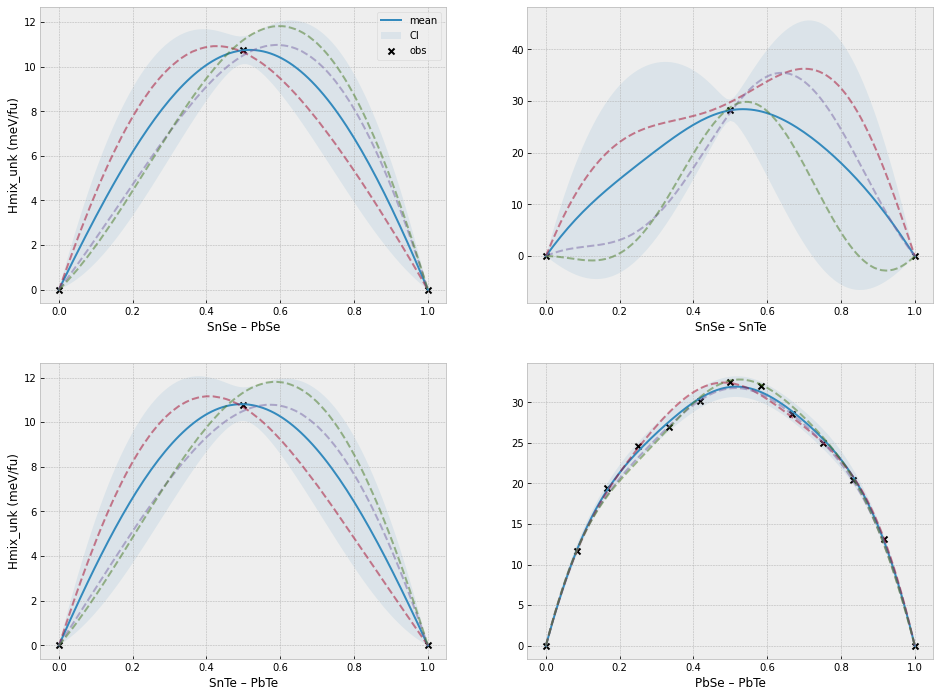

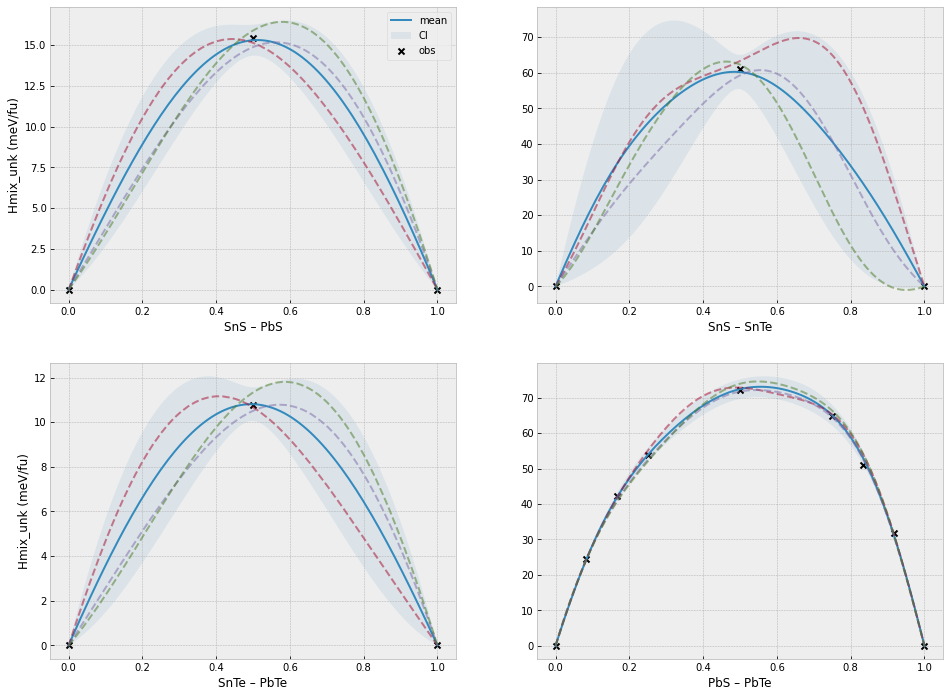

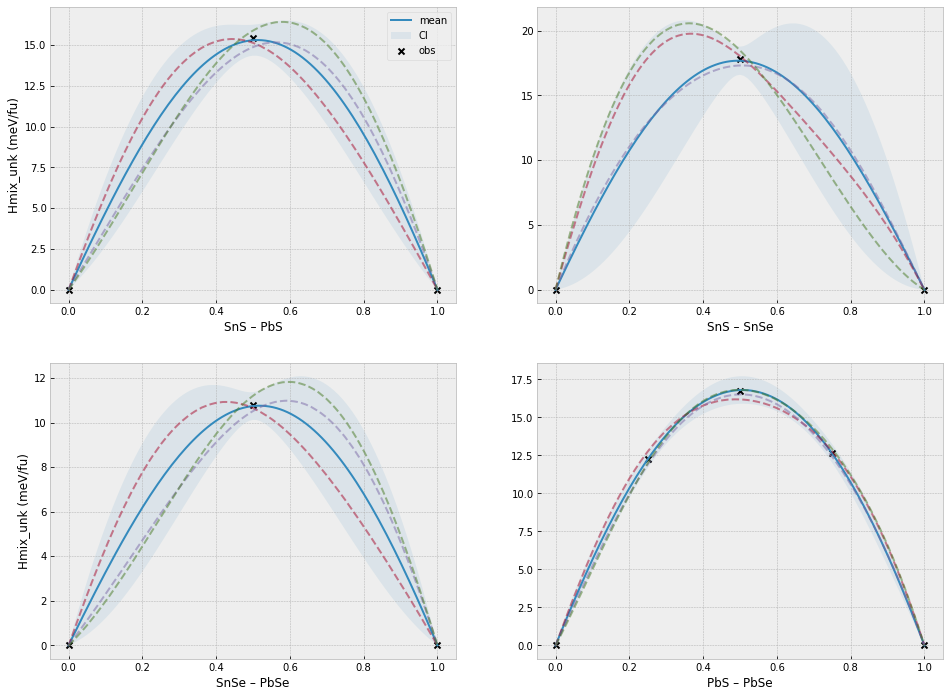

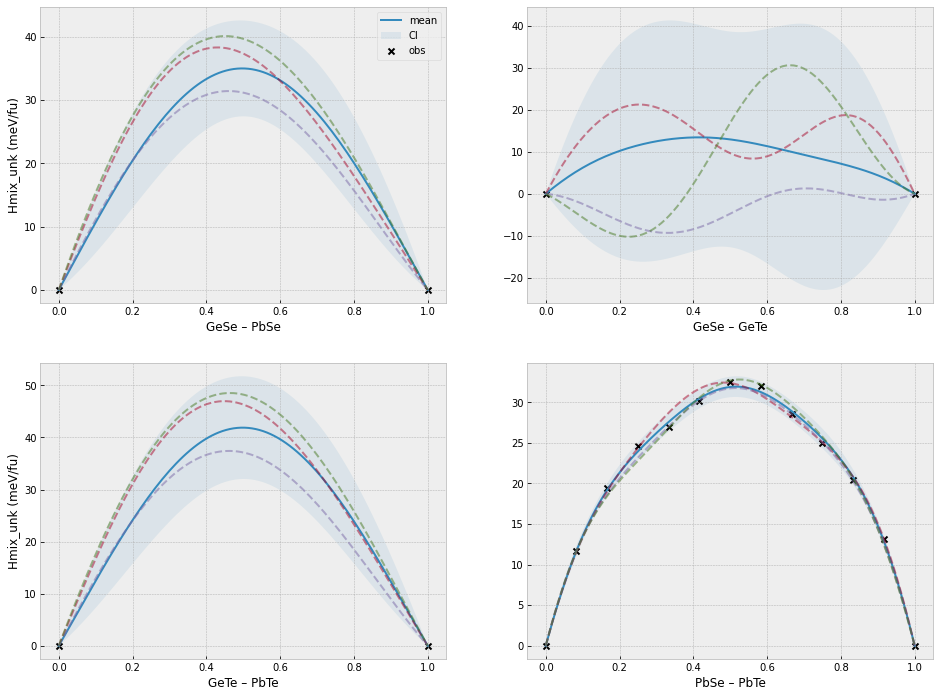

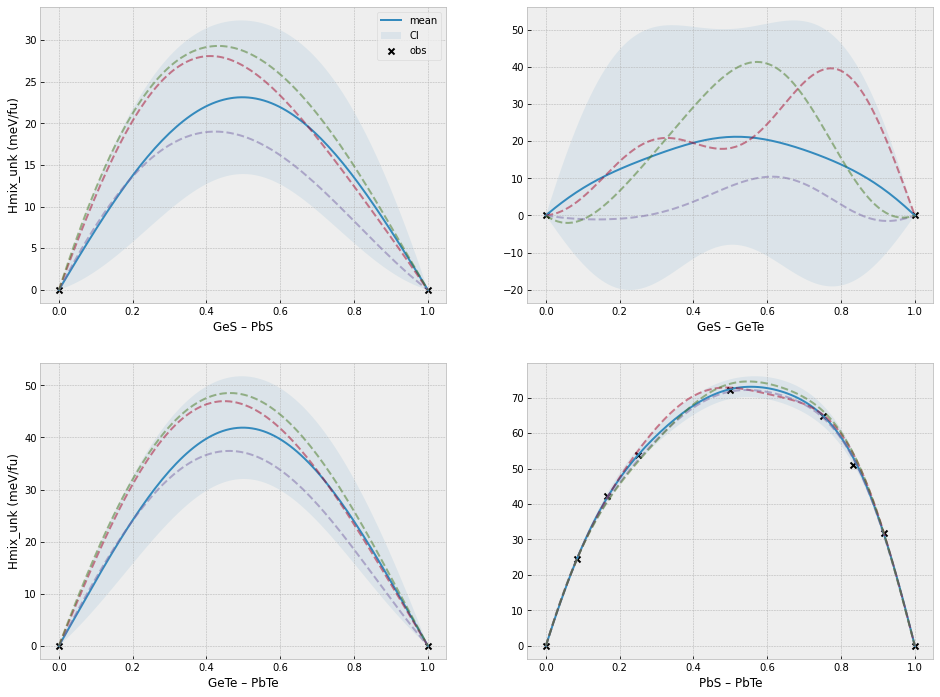

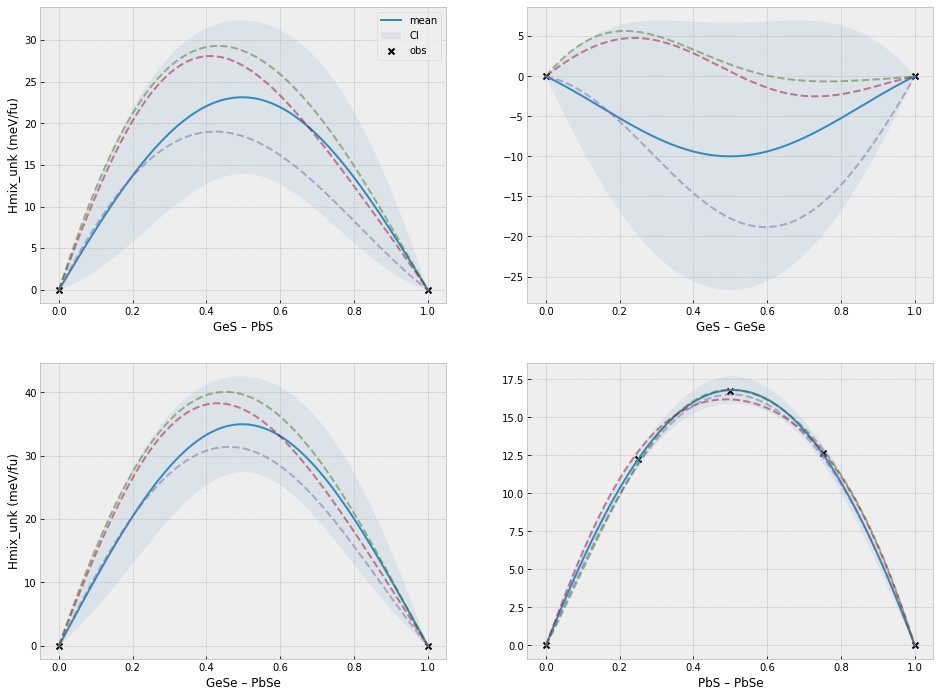

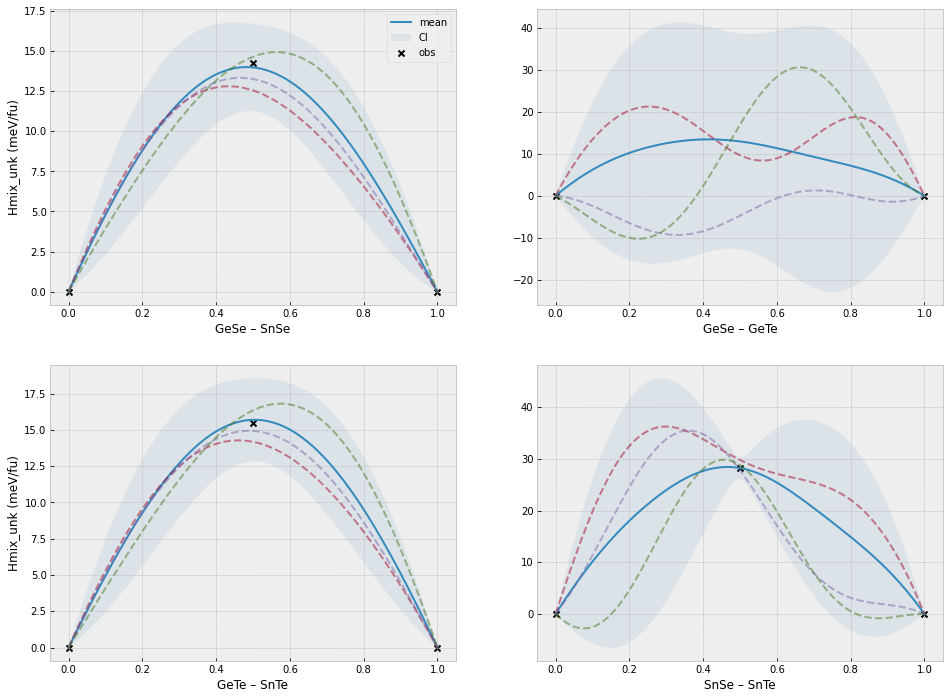

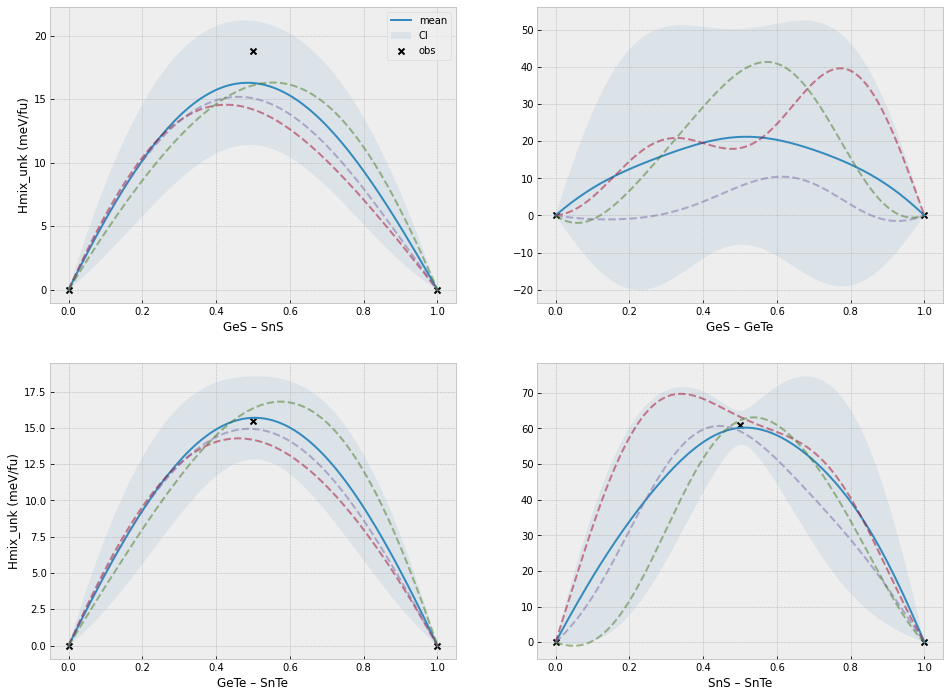

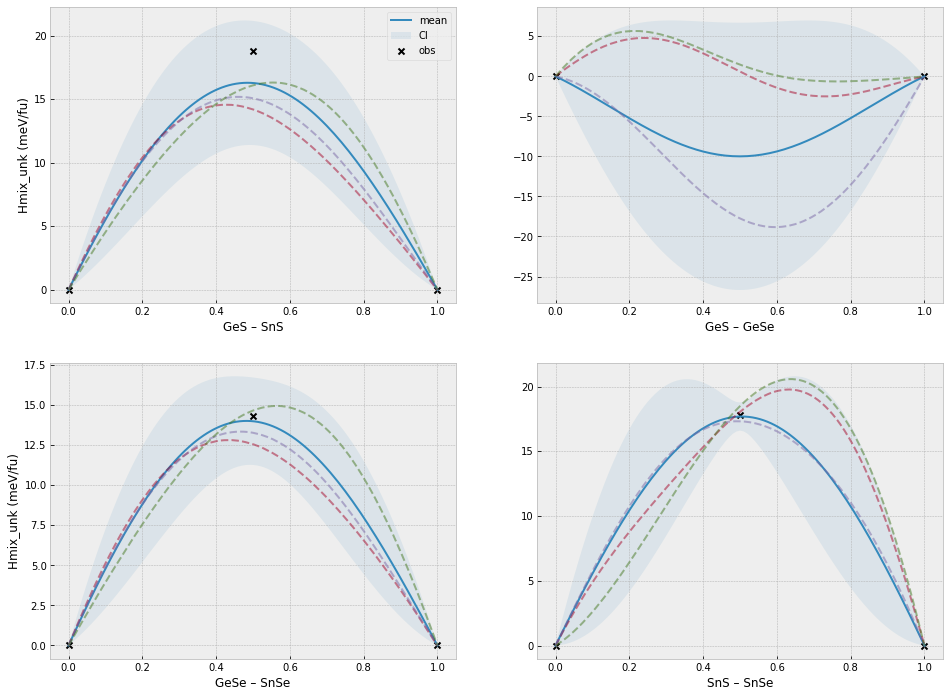

In [18]:
for cat_ind1 in range(2):
    for cat_ind2 in range(cat_ind1 + 1, 3):
        for an_ind1 in range(3, 5):
            for an_ind2 in range(an_ind1 + 1, 6):
                fig, ax = plot_regressor_square_edges(
                    cat_ind1,
                    cat_ind2,
                    an_ind1,
                    an_ind2,
                    model,
                    likelihood,
                    train_x,
                    train_y,
                    test_x,
                    unnormalize_fn=unnormalize_fn,
                )
                
                if track_wandb:
                    wandb_run.log(
                        {f"{CATS[cat_ind1]}{CATS[cat_ind2]}{ANS[an_ind1 - len(CATS)]}{ANS[an_ind2 - len(CATS)]}": wandb.Image(plt)}
                    )

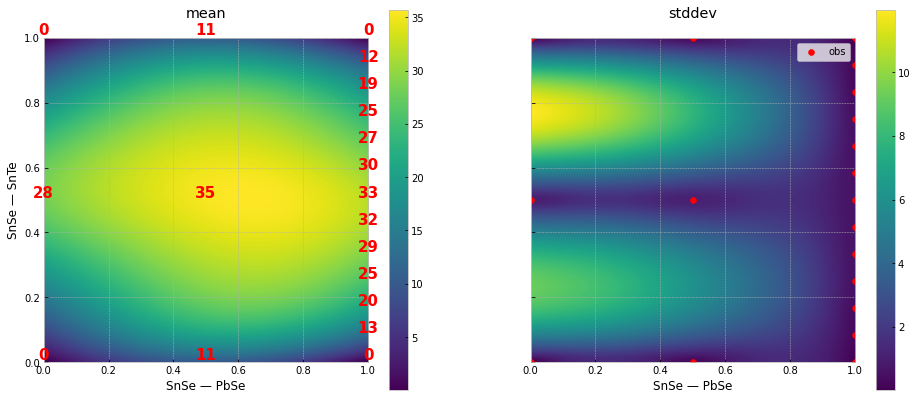

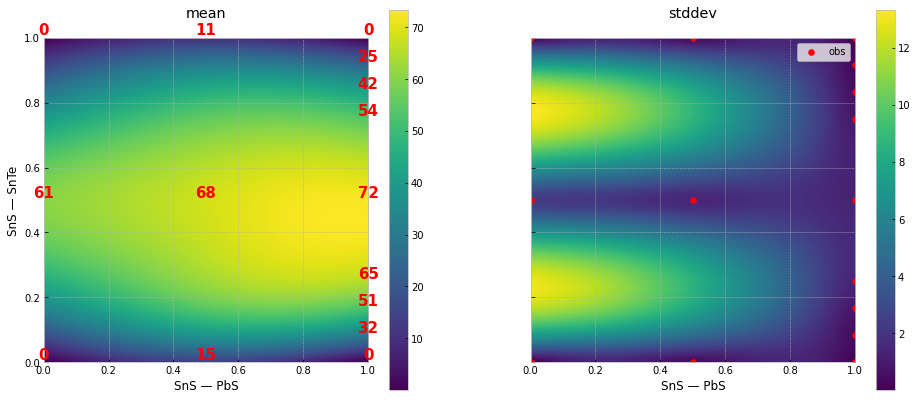

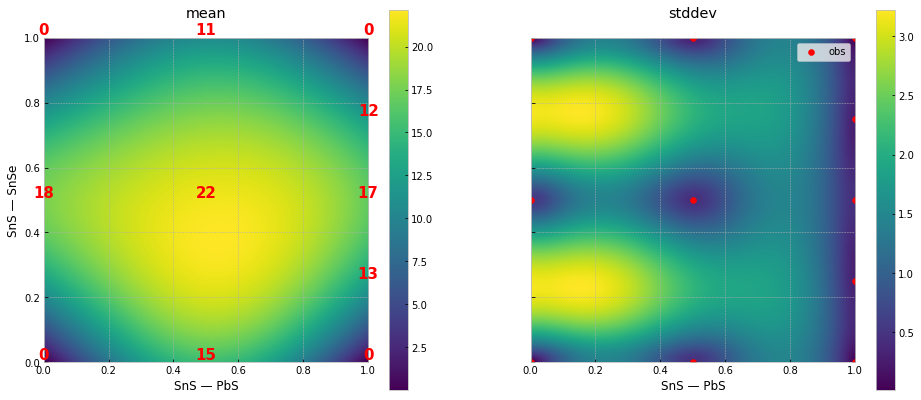

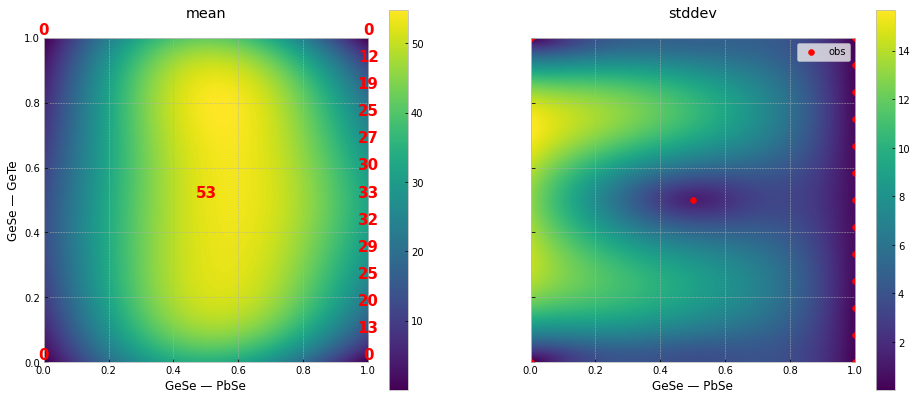

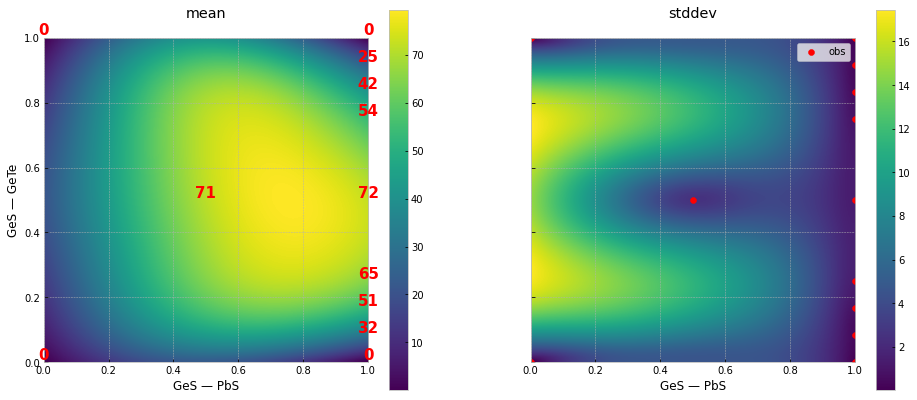

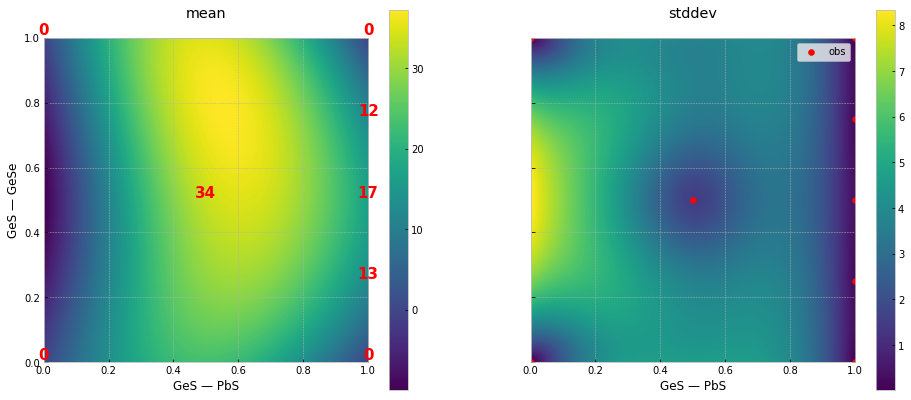

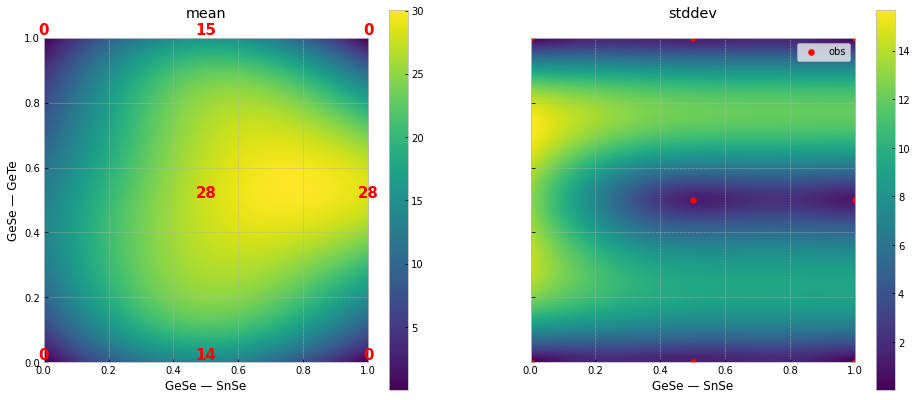

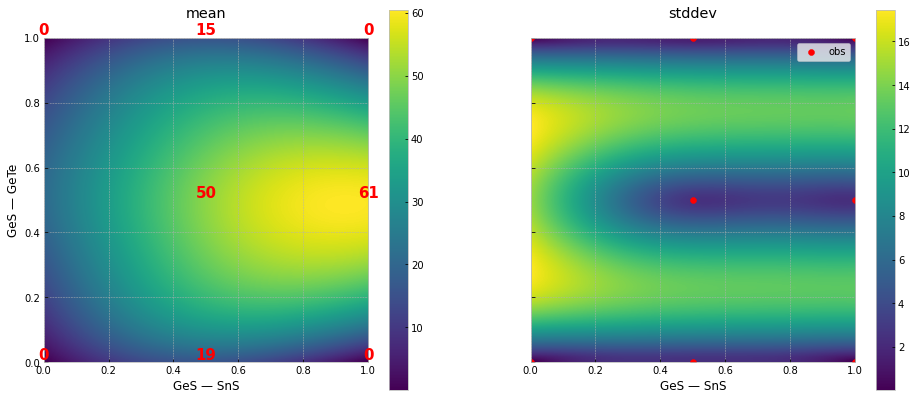

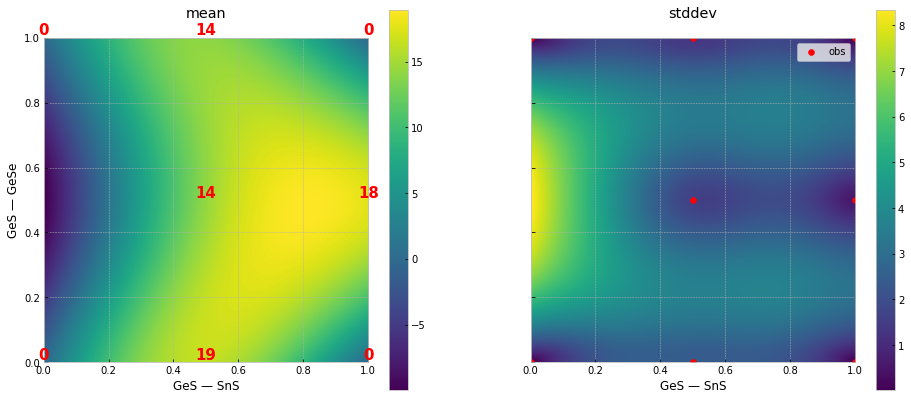

In [19]:
for cat_ind1 in range(2):
    for cat_ind2 in range(cat_ind1 + 1, 3):
        for an_ind1 in range(3, 5):
            for an_ind2 in range(an_ind1 + 1, 6):
                plot_regressor_square(
                    cat_ind1,
                    cat_ind2,
                    an_ind1,
                    an_ind2,
                    model,
                    likelihood,
                    train_x,
                    train_y,
                    test_x,
                    unnormalize_fn=unnormalize_fn,
                )
                
                if track_wandb:
                    wandb_run.log(
                        {f"{CATS[cat_ind1]}{CATS[cat_ind2]}{ANS[an_ind1 - len(CATS)]}{ANS[an_ind2 - len(CATS)]} square": wandb.Image(plt)}
                    )

In [20]:
if track_wandb:
    wandb_run.finish()

constant,█▇▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
iter,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
length scale for Ge,▃▁▁▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
length scale for Pb,▂▁▃▄▄▅▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
length scale for S,█▃▂▁▁▁▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇
length scale for Se,▁▁▁▁▁▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
length scale for Sn,▁▂▄▅▆▆▇▇▇▇██████████████████████████████
length scale for Te,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
output scale,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
constant,-2.39277


In [19]:
with torch.no_grad():
    output = model(test_x)
    mean = output.mean
    stddev = output.stddev

In [20]:
model.covar_module.base_kernel.lengthscale

tensor([[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]],
       grad_fn=<AddBackward0>)

In [21]:
all_lengthscales = model.covar_module.base_kernel.lengthscale.detach()
first_lengthscale = model.covar_module.base_kernel.lengthscale.detach().flatten()[0]

assert torch.all(
    torch.isclose(
        all_lengthscales,
        torch.ones_like(all_lengthscales) * first_lengthscale
    )
)

In [22]:
result_df = pd.read_csv("../data/space_w_feats.csv")

result_df["predictive_mean"] = unnormalize_fn(mean.detach()).numpy()
result_df["predictive_stddev"] = unnormalize_fn(stddev.detach()).numpy()

result_df.to_csv(f"lengthscale_{first_lengthscale:.4f}_predictions.csv")